In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


from datetime import datetime, date

In [54]:
# Load the CSV file into a DataFrame
df = pd.read_csv("fraud_data.csv")

# if the is_fraud feature is empty, it turns to NaN
df['is_fraud'] = pd.to_numeric(df['is_fraud'], errors='coerce')

# This will be data I use to train the models
data = {
    "transaction_year": [],
    "transaction_month": [],
    "transaction_day": [],
    "transaction_hour": [],
    "transaction_minute": [],
    
    "age": [],
    
    "is_fraud": df['is_fraud'].values
}

# Parse the 'trans_date_trans_time' column and extract date components
for item in df['trans_date_trans_time']:
    parsed_date = datetime.strptime(item, "%d-%m-%Y %H:%M")
    data["transaction_year"].append(parsed_date.year)
    data["transaction_month"].append(parsed_date.month)
    data["transaction_day"].append(parsed_date.day)
    data["transaction_hour"].append(parsed_date.hour)
    data["transaction_minute"].append(parsed_date.minute)

# Parse the 'dob' column and extract date components
for item in df['dob']:
    parsed_date = datetime.strptime(item, "%d-%m-%Y")
    today = date.today()
    
    age = today.year - parsed_date.year - ((today.month, today.day) < (parsed_date.month, parsed_date.day))
    
    data["age"].append(age)

In [55]:
# 1. Compute the frequency of each merchant
merchant_counts = df['merchant'].value_counts()

"""
2. Most merchants appear too little to be able to give us information
on whether the specific merchant is correlated with fraud. I chose
30 because that is typically the smallest sample size used to get a
statistically significant result.
"""
merchants_less_than_30 = merchant_counts[merchant_counts < 30]
percentage_less_than_30 = (len(merchants_less_than_30) / len(merchant_counts)) * 100
print(f"Percentage of merchants that appear less than 30 times: {percentage_less_than_30:.2f}%")

# 3. Create a new column in df that maps the merchant frequency to each row.
df['merchant_freq'] = df['merchant'].map(merchant_counts)

# 4. Compute the correlation between merchant frequency and is_fraud
correlation = df[['merchant_freq', 'is_fraud']].corr()
print(correlation) # Weak correlation woooohooooo. Maybe will use it to create a weak learner?

# 5. Add to the data object
data['merchant_freq'] = df['merchant_freq'].values

Percentage of merchants that appear less than 30 times: 84.27%
               merchant_freq  is_fraud
merchant_freq       1.000000  0.121829
is_fraud            0.121829  1.000000


In [56]:
# WE CAN USE THE SPECIFIC CITY TO DETECT FRAUD BECAUSE THE COUNT IS OVER
# 30 FOR MOST OF THEM. HOWEVER, THAT SEEMS LIKE TOO MUCH RIGHT NOW NGL

# 1. Compute the frequency of each city
city_count = df['city'].value_counts()
state_count = df['state'].value_counts()
job_count = df['job'].value_counts()

# 2. Create a new column in df that maps cities to city frequency for each row.
df['city_freq'] = df['city'].map(city_count)
df['state_freq'] = df['state'].map(state_count)

# 3. Compute the correlation between merchant frequency and is_fraud
correlation = df[['city_freq', 'is_fraud']].corr()
print(correlation) # Weak negative correlation!!! Another weak learner!!

correlation = df[['state_freq', 'is_fraud']].corr()
print(correlation) # So weakly correlated it's useless.

# 4. Add useful data
data['city_freq'] = df['city_freq'].values

           city_freq  is_fraud
city_freq   1.000000 -0.188793
is_fraud   -0.188793  1.000000
            state_freq  is_fraud
state_freq    1.000000 -0.015636
is_fraud     -0.015636  1.000000


In [57]:
# add features to the data dictionary
data['city_pop'] = df['city_pop'].values
data['amt'] = df['amt'].values
data['lat'] = df['lat'].values
data['long'] = df['long'].values
data['merch_lat'] = df['merch_lat'].values
data['merch_long'] = df['merch_long'].values

# convert dictionary to dataframe
data = pd.DataFrame(data)

# One hot encode cities
dummies = pd.get_dummies(df['state'], prefix='state').astype(int)
data = pd.concat([data, dummies], axis=1)

# One hot encode categories.
dummies = pd.get_dummies(df['category'], prefix='category').astype(int)
data = pd.concat([data, dummies], axis=1)

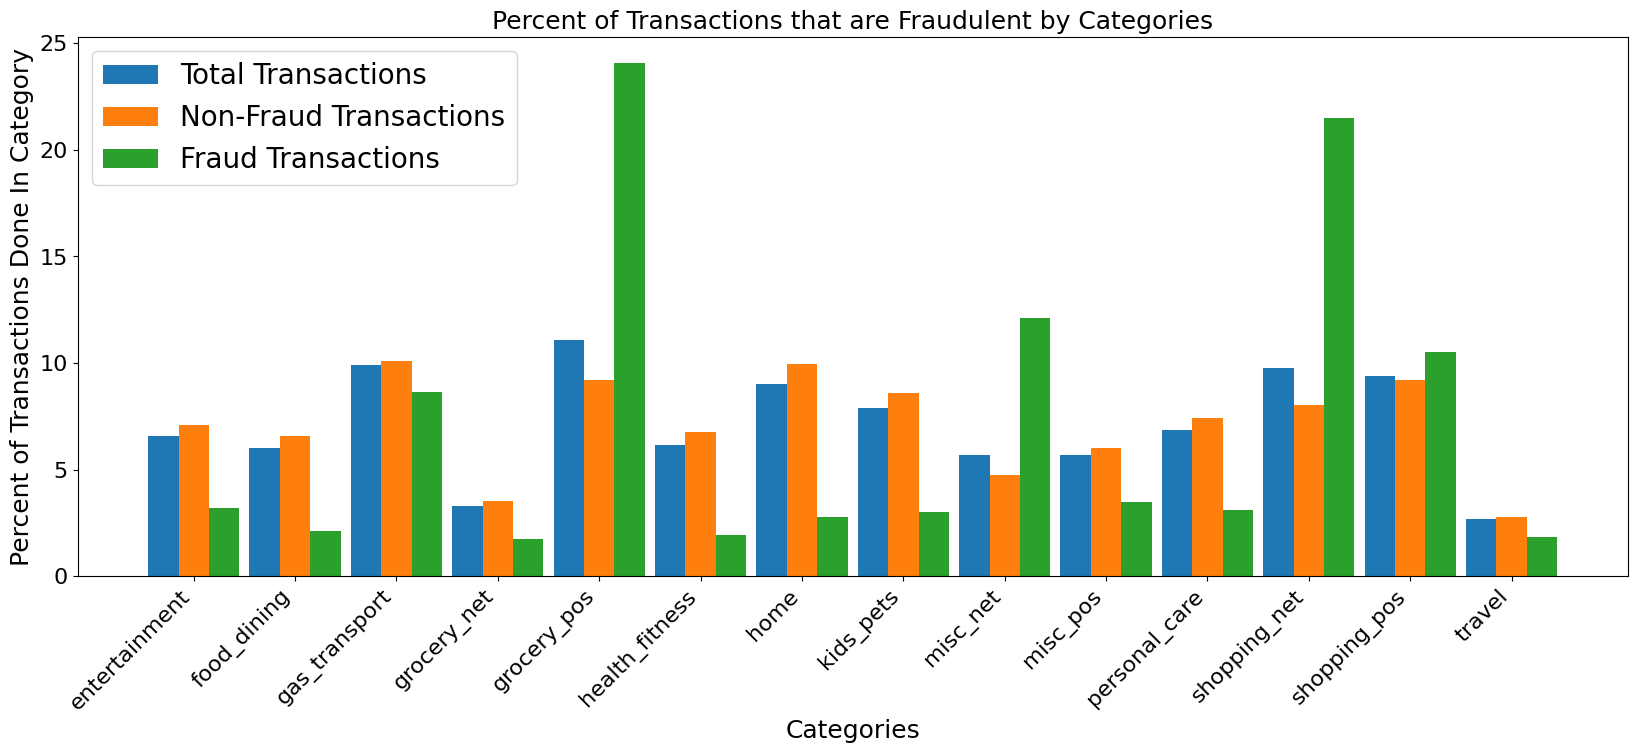

In [58]:
# Visauling Fraud by Categories

# grab categories, splitting into full, fraud, and non-fraud
categories = df.groupby('category').size().reset_index(name='fraud_count')
nonfraud_by_categories = df[df['is_fraud'] == 0].groupby('category').size().reset_index(name='fraud_count')
fraud_by_categories = df[df['is_fraud'] == 1].groupby('category').size().reset_index(name='fraud_count')

# convert counts to percentages
categories['fraud_count'] = 100 * categories['fraud_count'] / categories['fraud_count'].sum()
nonfraud_by_categories['fraud_count'] = 100 * nonfraud_by_categories['fraud_count'] / nonfraud_by_categories['fraud_count'].sum()
fraud_by_categories['fraud_count'] = 100 * fraud_by_categories['fraud_count'] / fraud_by_categories['fraud_count'].sum()

# Merge data to ensure alignment across all categories
merged = categories.merge(nonfraud_by_categories, on='category', how='left', suffixes=('_total', '_nonfraud'))
merged = merged.merge(fraud_by_categories, on='category', how='left')
merged.rename(columns={'fraud_count': 'fraud_count_fraud'}, inplace=True)

# Set positions for bars
x = np.arange(len(merged['category']))  # Label locations
width = 0.3  # Width of bars

# Plot bars
plt.figure(figsize=(20, 7))
plt.bar(x - width, merged['fraud_count_total'], width=width, label='Total Transactions')
plt.bar(x, merged['fraud_count_nonfraud'], width=width, label='Non-Fraud Transactions')
plt.bar(x + width, merged['fraud_count_fraud'], width=width, label='Fraud Transactions')

# Labels and title
plt.xlabel('Categories', fontsize=18)
plt.ylabel('Percent of Transactions Done In Category', fontsize=18)
plt.title('Percent of Transactions that are Fraudulent by Categories', fontsize=18)
plt.xticks(x, merged['category'], rotation=45, ha="right", fontsize=16)  # Rotate category names for better visibility
plt.yticks(fontsize=16)
plt.legend()
plt.show()

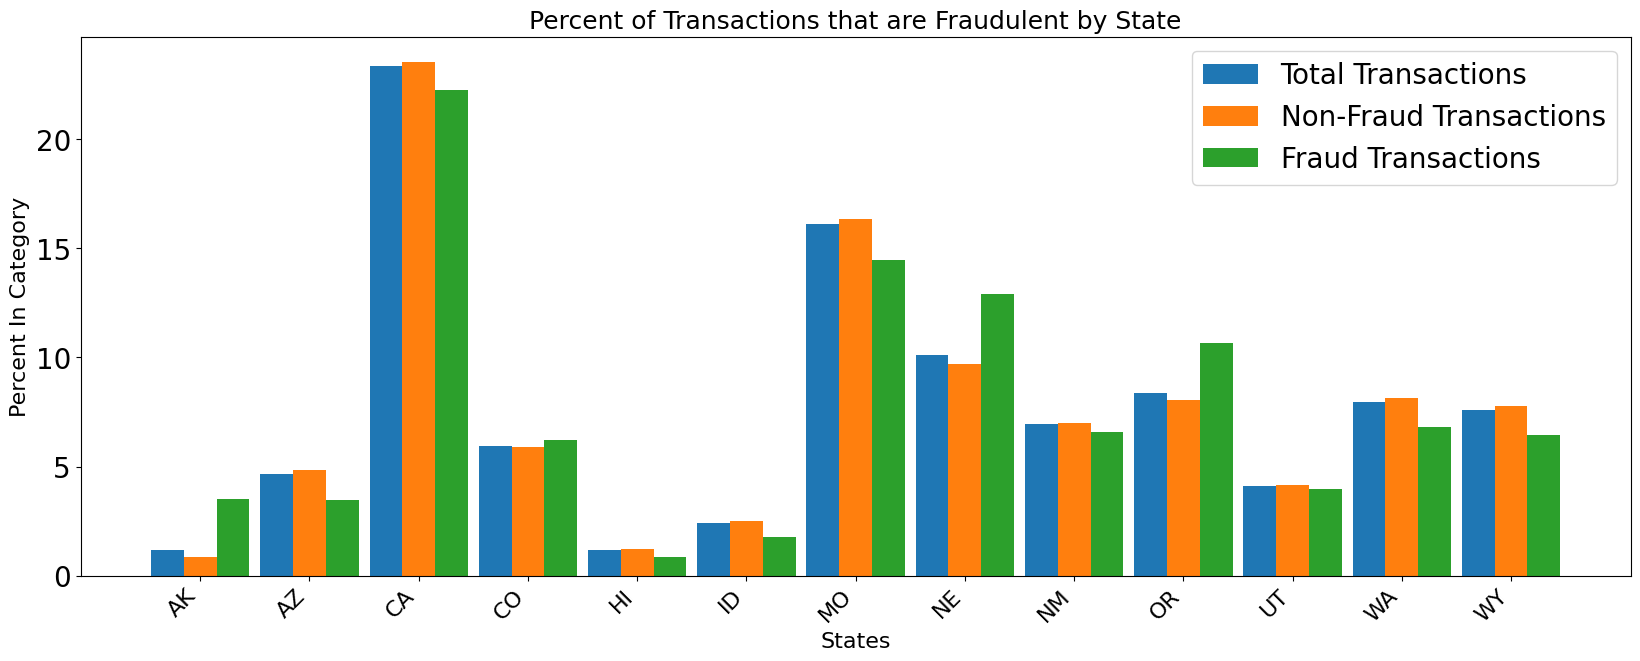

In [59]:
# Visauling Fraud by States

# grab data for states, splitting into full, fraud, and non-fraud
categories = df.groupby('state').size().reset_index(name='fraud_count')
nonfraud_by_categories = df[df['is_fraud'] == 0].groupby('state').size().reset_index(name='fraud_count')
fraud_by_categories = df[df['is_fraud'] == 1].groupby('state').size().reset_index(name='fraud_count')

# convert to percentages
categories['fraud_count'] = 100 * categories['fraud_count'] / categories['fraud_count'].sum()
nonfraud_by_categories['fraud_count'] = 100 * nonfraud_by_categories['fraud_count'] / nonfraud_by_categories['fraud_count'].sum()
fraud_by_categories['fraud_count'] = 100 * fraud_by_categories['fraud_count'] / fraud_by_categories['fraud_count'].sum()

# Merge data to ensure alignment across all categories
merged = categories.merge(nonfraud_by_categories, on='state', how='left', suffixes=('_total', '_nonfraud'))
merged = merged.merge(fraud_by_categories, on='state', how='left')
merged.rename(columns={'fraud_count': 'fraud_count_fraud'}, inplace=True)

# Set positions for bars
x = np.arange(len(merged['state']))  # Label locations
width = 0.3  # Width of bars

# Plot bars
plt.figure(figsize=(20, 7))
plt.bar(x - width, merged['fraud_count_total'], width=width, label='Total Transactions')
plt.bar(x, merged['fraud_count_nonfraud'], width=width, label='Non-Fraud Transactions')
plt.bar(x + width, merged['fraud_count_fraud'], width=width, label='Fraud Transactions')

# Labels and title
plt.xlabel('States', fontsize=16)
plt.ylabel('Percent In Category', fontsize=16)
plt.title('Percent of Transactions that are Fraudulent by State', fontsize=18)
plt.xticks(x, merged['state'], rotation=45, ha="right", fontsize=16)  # Rotate category names for better visibility
plt.legend()
plt.show()

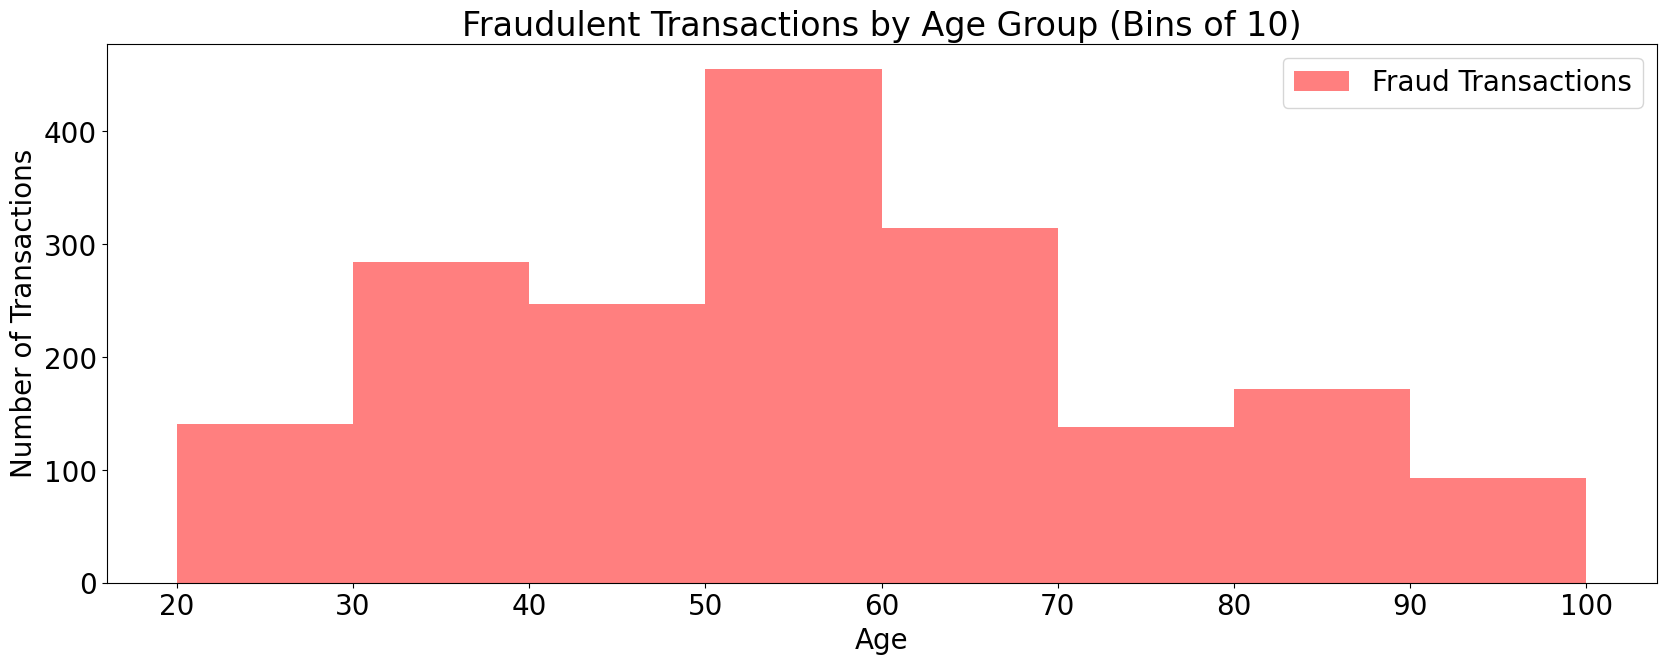

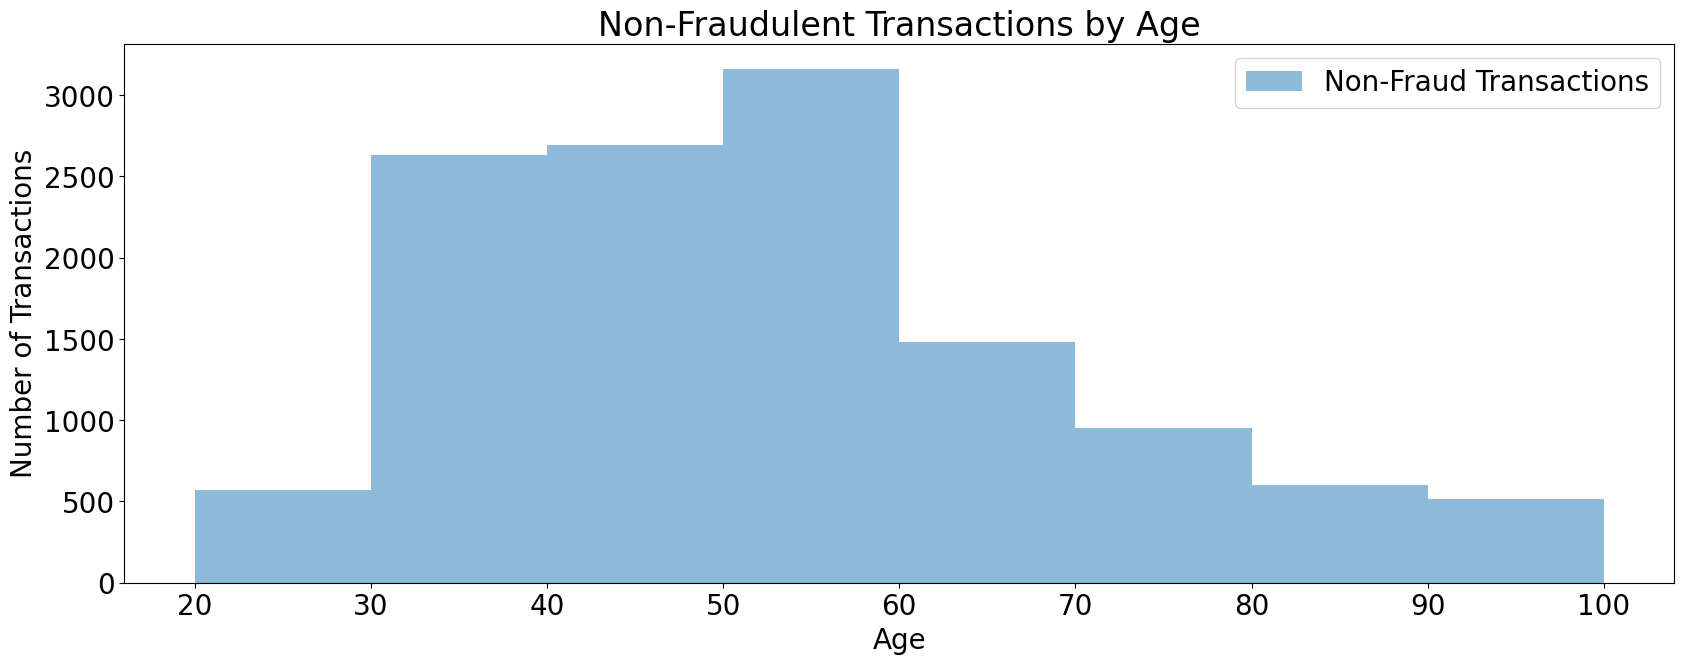

In [60]:
# Define the bins – groups of 10 years.
min_age = data['age'].min()
max_age = data['age'].max()
bins = np.arange(min_age - (min_age % 10), max_age + 10, 10)

# Create histograms for each group
plt.figure(figsize=(20, 7))
plt.hist(data[data['is_fraud'] == 1]['age'], bins=bins, alpha=0.5, label='Fraud Transactions', color='red')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Number of Transactions')
plt.title('Fraudulent Transactions by Age Group (Bins of 10)')
plt.legend()
plt.show()

# Create histograms for each group
plt.figure(figsize=(20, 7))
plt.hist(data[data['is_fraud'] == 0]['age'], bins=bins, alpha=0.5, label='Non-Fraud Transactions')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Number of Transactions')
plt.title('Non-Fraudulent Transactions by Age')
plt.legend()
plt.show()

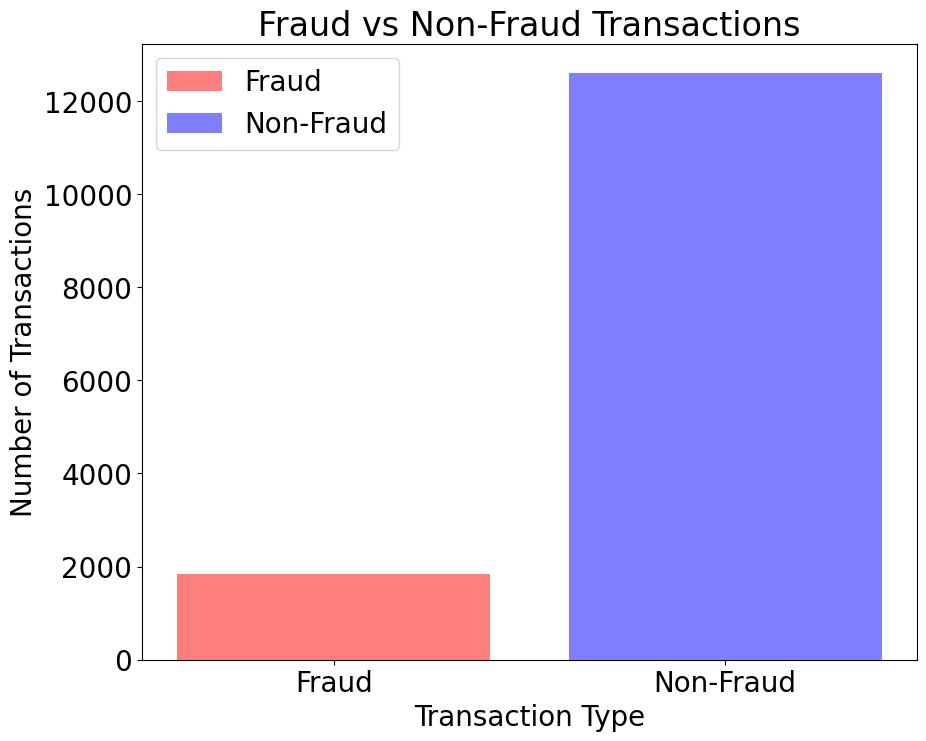

In [61]:
# split fraud data and non-fraud data
fraud_data = data[data['is_fraud'] == 1]
non_fraud_data = data[data['is_fraud'] == 0]

# display bar graph
plt.figure(figsize=(10, 8))
plt.bar("Fraud", len(fraud_data), color='red', alpha=0.5, label='Fraud')
plt.bar("Non-Fraud", len(non_fraud_data), color='blue', alpha=0.5, label='Non-Fraud')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.title('Fraud vs Non-Fraud Transactions')
plt.legend()
plt.show()

In [62]:
# drop empty samples
data = data.dropna(subset=['is_fraud'])

# drop time related features in main set
data_with_time = data
data = data.drop(columns=['transaction_year', 'transaction_month', 'transaction_day', 'transaction_hour', 'transaction_minute'])

# print number of samples
print(f"Total number of transactions: {len(data)}")

Total number of transactions: 14444


In [63]:
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

# Separate features (X) and target variable (y) from the dataset
X = data.drop(['is_fraud'], axis=1)   # Drop the target column to get the feature matrix
y = data['is_fraud']                # Target variable indicating if a transaction is fraudulent

# print(X.columns)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test data
X_test_scaled = scaler.transform(X_test)

In [64]:
def k_fold_accuracy(model, n_folds):
    # get k-fold cross validation results for any model
    k_fold_rf = KFold(n_splits=n_folds)
    cv_results_rf = cross_val_score(model, X_train_scaled, y_train, cv = k_fold_rf)

    # print the results
    print("="*50)
    print("Cross-Validation Results")
    print("="*50)
    print("Accuracies:")    

    # print the accuracies for each fold
    for i, accuracy in enumerate(cv_results_rf):
        print(f"  Fold {i+1}: {accuracy:.4f}")

    # get average accuracy
    average_accuracy = cv_results_rf.mean()

    # print the average accuracy
    print(f"\nAverage Accuracy: {average_accuracy:.4f}")
    print("="*50)

    return average_accuracy


In [65]:
# Initialize a Logistic Regression model with a higher max_iter to ensure convergence
LogisticRegressionModel = LogisticRegression(max_iter=1000)

# Train the logistic regression model on the scaled training data
LogisticRegressionModel.fit(X_train_scaled, y_train)

# Use the trained model to predict labels for the scaled test data
y_pred = LogisticRegressionModel.predict(X_test_scaled)

In [66]:
# print accuracy, confusion matrix, metrics, and K-fold accuracies

print("="*50)
print("Logistic Regression Results")
print("="*50)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred, normalize="true"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

k_fold_accuracy(LogisticRegressionModel, 5)

Logistic Regression Results
Accuracy: 0.9442713741779163

Confusion Matrix:
 [[0.99000799 0.00999201]
 [0.35142119 0.64857881]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      2502
         1.0       0.91      0.65      0.76       387

    accuracy                           0.94      2889
   macro avg       0.93      0.82      0.86      2889
weighted avg       0.94      0.94      0.94      2889

Cross-Validation Results
Accuracies:
  Fold 1: 0.9494
  Fold 2: 0.9420
  Fold 3: 0.9407
  Fold 4: 0.9489
  Fold 5: 0.9502

Average Accuracy: 0.9463


0.9462570315880571

In [67]:
# Initialize a Random Forest Classifier
RandomForestModel = RandomForestClassifier()

# Train the model on the scaled training data
RandomForestModel.fit(X_train_scaled, y_train)

# Predict the target variable for the scaled test data
y_pred = RandomForestModel.predict(X_test_scaled)

In [68]:
# print accuracy, confusion matrix, metrics, and K-fold accuracies

print("="*50)
print("Random Forest Results")
print("="*50)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred, normalize="true"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

k_fold_accuracy(RandomForestModel, 5)

Random Forest Results
Accuracy: 0.9792315680166147

Confusion Matrix:
 [[0.99360512 0.00639488]
 [0.11369509 0.88630491]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2502
         1.0       0.96      0.89      0.92       387

    accuracy                           0.98      2889
   macro avg       0.97      0.94      0.95      2889
weighted avg       0.98      0.98      0.98      2889

Cross-Validation Results
Accuracies:
  Fold 1: 0.9701
  Fold 2: 0.9710
  Fold 3: 0.9719
  Fold 4: 0.9797
  Fold 5: 0.9727

Average Accuracy: 0.9731


0.9730852444829079

In [69]:
# Initialize a Decision Tree Classifier of max_depth = 1
DecisionStumpModel = DecisionTreeClassifier(max_depth = 1)

# Train the model on the scaled training data
DecisionStumpModel.fit(X_train, y_train)

# Predict the target variable for the scaled test data
y_pred = DecisionStumpModel.predict(X_test)

In [70]:
# print accuracy, confusion matrix, metrics, and K-fold accuracies

print("="*50)
print("Decision Stump Results")
print("="*50)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred, normalize="true"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

k_fold_accuracy(DecisionStumpModel, 5)

Decision Stump Results
Accuracy: 0.9463482173762547

Confusion Matrix:
 [[0.97482014 0.02517986]
 [0.2377261  0.7622739 ]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      2502
         1.0       0.82      0.76      0.79       387

    accuracy                           0.95      2889
   macro avg       0.89      0.87      0.88      2889
weighted avg       0.94      0.95      0.95      2889

Cross-Validation Results
Accuracies:
  Fold 1: 0.9459
  Fold 2: 0.9373
  Fold 3: 0.9373
  Fold 4: 0.9546
  Fold 5: 0.9459

Average Accuracy: 0.9442


0.9441800086542622

In [71]:
# Initialize a Gradient Boosting Model
GradientBoostingModel = GradientBoostingClassifier()

# Train the model on the scaled training data
GradientBoostingModel.fit(X_train, y_train)

# Predict the target variable for the scaled test data
y_pred = GradientBoostingModel.predict(X_test)

In [72]:
# print accuracy, confusion matrix, metrics, and K-fold accuracies

print("="*50)
print("Gradient Boosting Results")
print("="*50)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred, normalize="true"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

k_fold_accuracy(GradientBoostingModel, 5)

Gradient Boosting Results
Accuracy: 0.9775

Confusion Matrix:
 [[0.99360512 0.00639488]
 [0.12661499 0.87338501]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2502
         1.0       0.95      0.87      0.91       387

    accuracy                           0.98      2889
   macro avg       0.97      0.93      0.95      2889
weighted avg       0.98      0.98      0.98      2889

Cross-Validation Results
Accuracies:
  Fold 1: 0.9723
  Fold 2: 0.9706
  Fold 3: 0.9693
  Fold 4: 0.9797
  Fold 5: 0.9710

Average Accuracy: 0.9726


0.972565988749459

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap

# Initialize a Random Forest Classifier, Gradient Boosting Classifier, and a Logistic Regression
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
log_reg = make_pipeline(StandardScaler(), LogisticRegression(solver='saga', max_iter=1000))

# Create a Voting Classifier ensemble with the three aforementioned models
ensemble = VotingClassifier(estimators = [
    ('rf', rf),
    ('gb', gb),
    ('log_reg', log_reg)
])

# Fit the ensemble model on the training data
ensemble.fit(X_train, y_train)

# Predict using the ensemble model on the test data
y_pred = ensemble.predict(X_test)

# get the accuracy of the ensemble model
acc_ensemble = accuracy_score(y_test, y_pred)


Voting Classifier (ensemble) Results
Accuracy Score: 0.9772

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2502
         1.0       0.95      0.87      0.91       387

    accuracy                           0.98      2889
   macro avg       0.97      0.93      0.95      2889
weighted avg       0.98      0.98      0.98      2889

Cross-Validation Results
Accuracies:
  Fold 1: 0.9697
  Fold 2: 0.9689
  Fold 3: 0.9637
  Fold 4: 0.9715
  Fold 5: 0.9715
  Fold 6: 0.9732
  Fold 7: 0.9766
  Fold 8: 0.9784
  Fold 9: 0.9714
  Fold 10: 0.9688

Average Accuracy: 0.9714


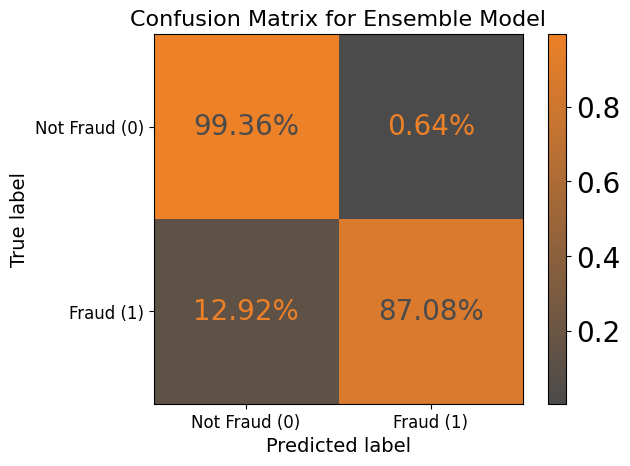

In [74]:
# print the results
print("="*50)
print("Voting Classifier (ensemble) Results")
print("="*50)
print(f"Accuracy Score: {acc_ensemble:.4f}\n")

# create a cusom confusion matrix
cm_ensemble = confusion_matrix(y_test, y_pred, normalize="true")

# create and display a custom colormap
color_map = LinearSegmentedColormap.from_list("custom_color", ['#4B4B4B', '#ED8128'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=['Not Fraud (0)', 'Fraud (1)'])

# get the axes for conversion to percentages
_, axis = plt.subplots()

# plot matrix
disp.plot(cmap=color_map, ax=axis, values_format='.4f', )

# edit title and labels
disp.ax_.set_title("Confusion Matrix for Ensemble Model", fontsize=16)
disp.ax_.set_xlabel('Predicted label', fontsize=14)
disp.ax_.set_ylabel('True label', fontsize=14)
disp.ax_.tick_params(axis='both', labelsize=12)

# convert matrix values to percentages
for text in axis.texts:
    text.set_text(f"{float(text.get_text()) * 100:.2f}%")

# print other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

# print K-fold results
acc_avg = k_fold_accuracy(ensemble, 10)

In [75]:

# Calulate the confidence interval for the accuracy
def CI(acc, n, z=1.96):
    stddev = np.sqrt((acc * (1 - acc)) / n)
    return acc - z * stddev, min(acc + z * stddev, 1.0)
    

In [76]:
# print num predictions and average accuracy across K-fold
print(f"n: {len(y_test)}")
print(f"Accuracy: {acc_avg:.4f}")

# compute and print confidence interval
confidence_interval = CI(acc_ensemble, len(y_test))
print(f"Confidence Interval: {confidence_interval[0]:.4f}-{confidence_interval[1]:.4f}")


n: 2889
Accuracy: 0.9714
Confidence Interval: 0.9717-0.9826


37


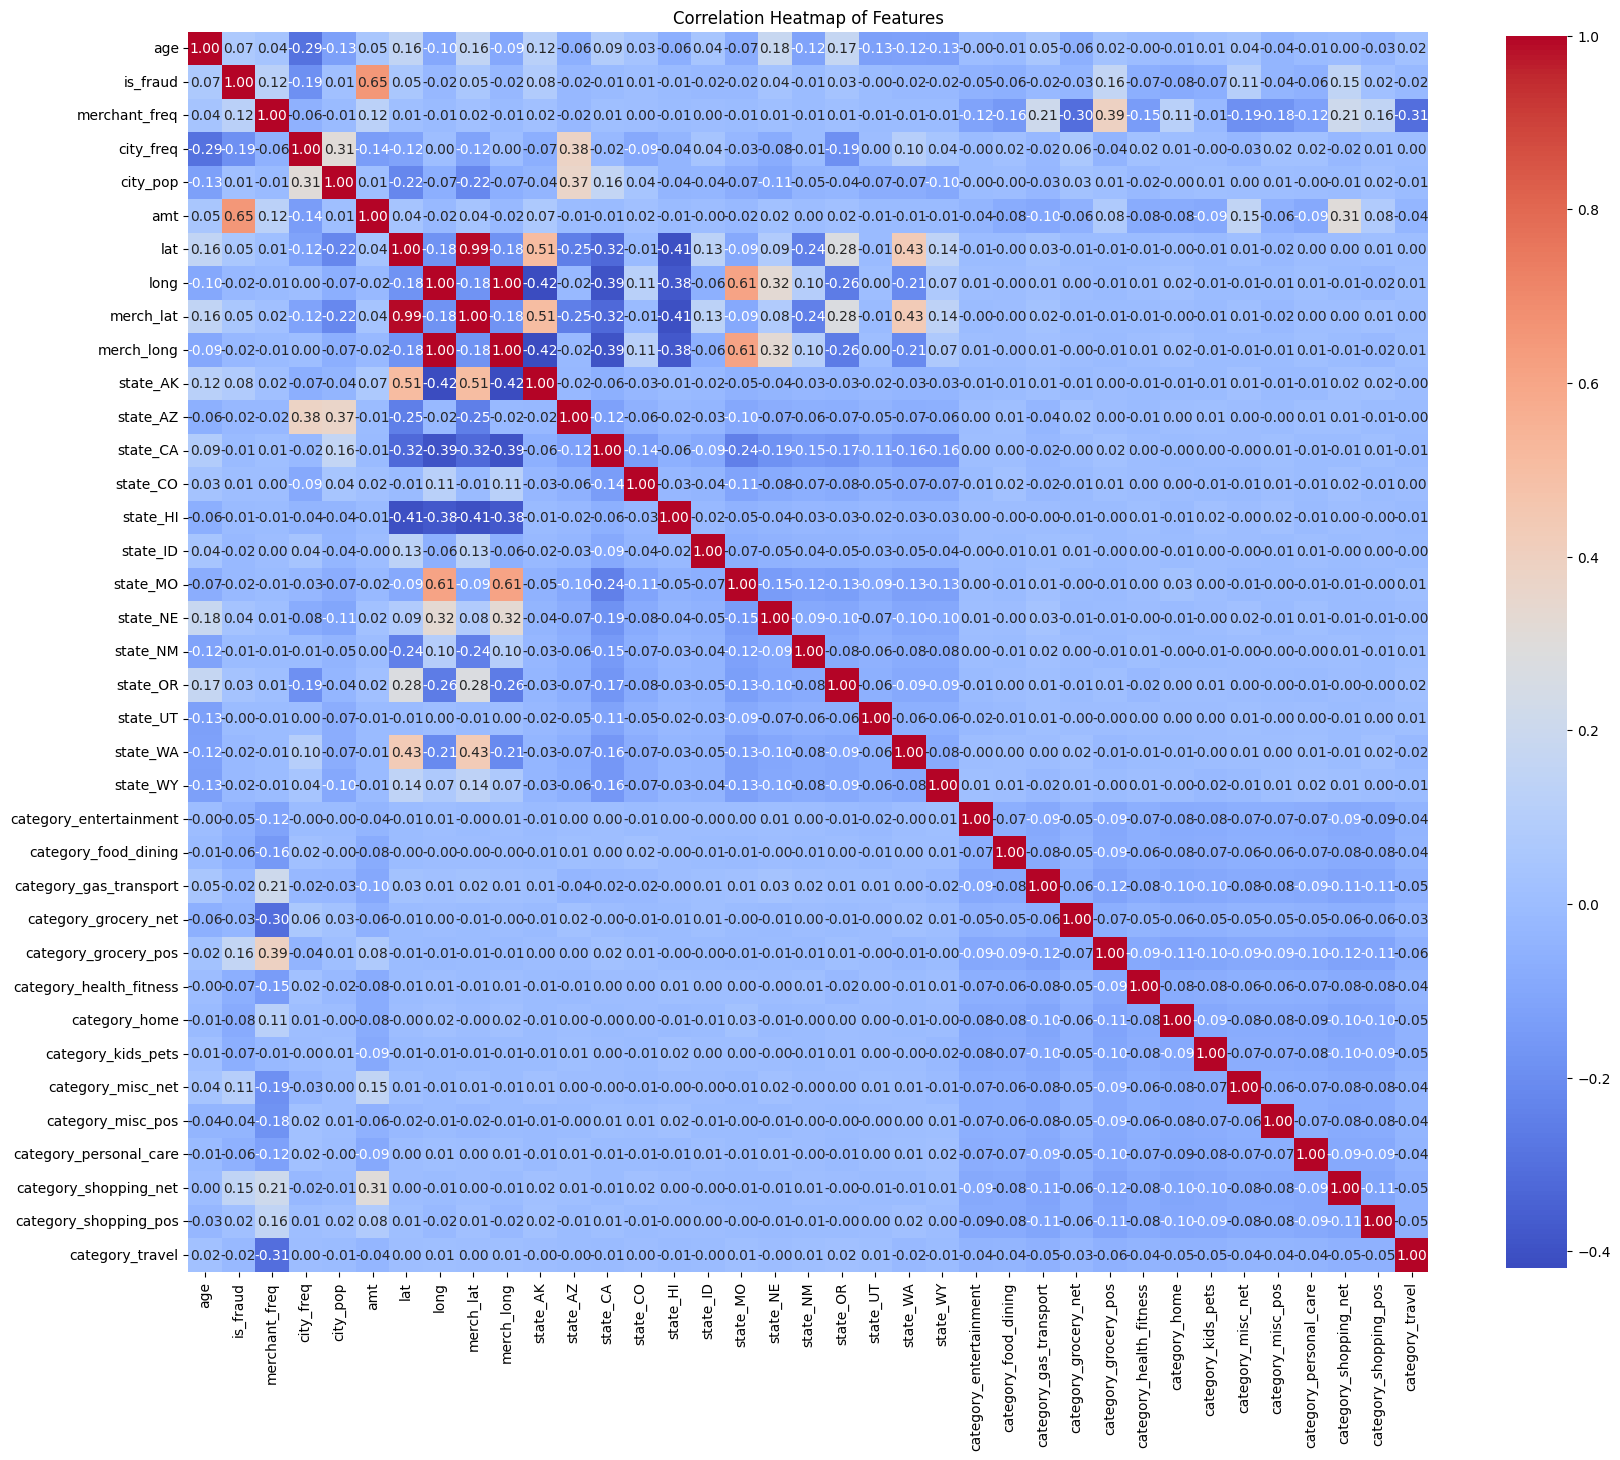

In [77]:
# get shape of data
print(data.shape[1])

# Plot the correlation heat map
correlation = data.corr()
plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 10})
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap of Features")
plt.show()


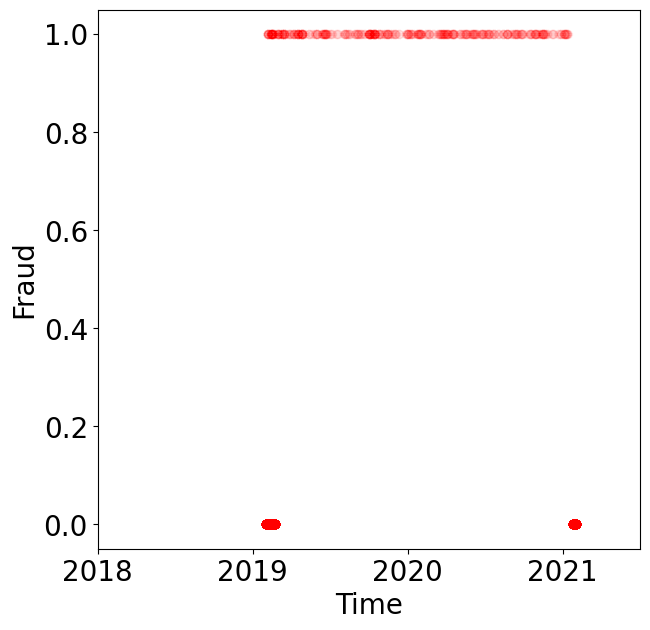

In [78]:
# display the fraud cases based on the recorded time

# get time features
XYear = data_with_time["transaction_year"].values
XMonth = data_with_time["transaction_month"].values
XDay = data_with_time["transaction_day"].values
XHour = data_with_time["transaction_hour"].values
# Gathered all of the time data to create a time array that I use to plot when the data was sampled
XTime = np.array([XYear + XMonth / 12 + XDay / 365 + XHour / 8760]).T

# get fraud values
YFraud = data_with_time["is_fraud"].values

# display a graph for them
plt.figure(figsize=(7, 7))
plt.rcParams.update({'font.size': 20})
plt.plot(XTime, YFraud, "ro", label='', alpha=0.01)
plt.xlabel('Time')
plt.ylabel('Fraud')
plt.xlim(2018, 2021.5)

plt.show()
